In [12]:
import pandas as pd
import numpy as np
import random
from random import choice
import math
import iexfinance
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import requests
from iexfinance.stocks import get_historical_data
from datetime import datetime
from iexfinance.stocks import Stock
import os
from dotenv import load_dotenv
load_dotenv()

iex_token = os.getenv('IEX_TOKEN')


In [13]:
def get_share_prices():
    
    start = datetime(2021, 6, 1)
    end = datetime(2022, 1, 4)

    df = get_historical_data('AAPL', start, end, output_format='pandas',token=iex_token, close_only=True)
    df = df.reset_index()
    #df.sort_values(by='updated', inplace=True, ascending=True)
    price_list = df['close'].tolist()
    trading_windows = len(price_list)
    
    return price_list, trading_windows

In [14]:
def pound_buy_order_generator(stock_price):

    simulations = 5
    unit_order = []
    pound_order = []
    #stock_price = round(random.uniform(0,5),2)
    print('__________')
    print('<<<<Client Buy Order>>>>')
    print('Stock Price = ' + str(stock_price))

    for i in range(simulations):
        order = round(random.uniform(1,1000),0)
        share_instruction = round(order/stock_price,2)
        print('Customer ' + str(i+1) + ' £' + str(order) + ' ' + str(share_instruction) + ' shares')
        unit_order.append(share_instruction)
        pound_order.append(order)
        i+=1

    pound_order = round(sum(pound_order),2)
    stock_order = round(sum(unit_order),2)
    
    fractional_order,whole_order = math.modf(stock_order)
    fractional_order = round(fractional_order,2)
    print('Total £ = ' + str(pound_order))
    print('Total Stock Buy Amount = ' + str(stock_order) + ' units')
    print('Fraction Amount = ' + str(round(fractional_order,2)) + ' units')
    print('<<<<>>>>')
    print(' ')
    
    return fractional_order,whole_order,stock_order

In [15]:
def pound_sell_order_generator(stock_price):

    simulations = 2
    unit_order = []
    pound_order = []
    #stock_price = round(random.uniform(0.5,1),2)
    print('')
    print('<<<<Client Sell Order>>>>')
    print('Stock Price = ' + str(stock_price))

    for i in range(simulations):
        order = -1 * round(random.uniform(1,1000),0)
        share_instruction = round(order/stock_price,2)
        print('Customer ' + str(i+1) + ' £' + str(order) + ' ' + str(share_instruction) + ' shares')
        unit_order.append(share_instruction)
        pound_order.append(order)
        i+=1

    pound_order = round(sum(pound_order),2)
    stock_order = round(sum(unit_order),2)
    
    fractional_order,whole_order = math.modf(stock_order)
    fractional_order = round(fractional_order,2)
    print('Total £ = ' + str(pound_order))
    print('Total Stock Sell Amount = ' + str(stock_order) + ' units')
    print('Fraction Amount = ' + str(round(-1*fractional_order,2)) + ' units')
    print('<<<<>>>>')
    print(' ')
    
    return fractional_order,whole_order,stock_order


In [16]:
def ie_purchase_instruction(ie_registry,stock_price):

    ticket = pound_buy_order_generator(stock_price)
    fractional_order = ticket[0]
    whole_shares = ticket[1]
    total_order = ticket[2]
        
    return fractional_order, total_order, whole_shares


In [17]:
def ie_ticket_instruction(ie_registry,stock_price):

    random_list = [0,1]
    random_list_pick = random.choice(random_list)
    
    function_selector = [pound_buy_order_generator, pound_sell_order_generator]
    
    random_function_selector = function_selector[random_list_pick]
    ticket = random_function_selector(stock_price)
    
    fractional_order, whole_shares, total_order = ticket
    
    print('Whole Share Transaction = ' + str(whole_shares))
    print('Fraction Share Order = ' + str(fractional_order))
    print('')
    
    return fractional_order, total_order, whole_shares

In [18]:
def fraction_model():

    #trading_window = 5
    ie_registry = 1
    start_amount = 0
    client_start = 0
    ie_purchases = 1
    ie_capacity = 2
    total_investment = [0]
    ie_total_registry = [1]
    ie_fraction_transactions = [1]
    total_unit_order = [1]

    for i in range(trading_windows):
        print('TRANSACTION ' + str(i+1))
        print('IE Registry = ' + str(round(ie_registry,2)))

        if i == 0:
            fractional_order, total_order, whole_shares = ie_purchase_instruction(ie_registry, price_list[i])
            total_investment.append(round(total_order*price_list[i],2))
            total_unit_order.append(round(total_order,2))
        else:
            fractional_order, total_order, whole_shares = ie_ticket_instruction(ie_registry, price_list[i])
            #fractional_order, total_order, whole_shares = ie_sell_instruction(ie_registry)            
            total_investment.append(round(total_order*price_list[i],2))
            total_unit_order.append(round(total_order,2))
            

        if total_order > 0:
            if fractional_order > ie_registry:

                client_fractional_purchase = round((fractional_order-ie_registry),2)
                ie_fraction_purchase = round((1 - client_fractional_purchase),2)

                print('####Transfer#####')
                print('IE Transfer to Client = ' + str(round(ie_registry,2)))
                print('#####TRADE Ticket#####')
                print('Client Order Whole Shares = ' + str(whole_shares))
                print('PLUS Client Funds Purchase = ' + str(client_fractional_purchase))
                print('PLUS IE Purchase = ' + str(ie_fraction_purchase))
                print('TICKET Total = ' + str(whole_shares+client_fractional_purchase+ie_fraction_purchase))
                print('##########')
                ie_fraction_movement = round((ie_fraction_purchase - ie_registry),2)
                ie_registry = 1 + round(ie_registry - fractional_order,2)

            else:
                print('#####TRADE Ticket#####')
                print('Client Order Whole Shares = ' + str(whole_shares))
                print('Fractional Transfer to Client from IE = ' + str(fractional_order))
                print('')
                ie_fraction_movement = -1 * fractional_order
                ie_registry = round((ie_registry - fractional_order),2)
                
            ie_total_registry.append(round(ie_registry,2))
            ie_fraction_transactions.append(round(ie_fraction_movement,2))

        else:
            ticket_sell_instruction = math.floor(total_order)
            sell_fraction_amount = -1 * fractional_order

            if sell_fraction_amount <= (ie_capacity - ie_registry):
                print('----------')
                print('####TRANSFER#####')
                print('IE Purchase from Clients = ' + str(sell_fraction_amount))
                print('#####TRADE Ticket#####')
                print('Client Ticket Instruction  = ' + str(-1 * whole_shares))
                print('----------')
                ie_fraction_movement = sell_fraction_amount
                ie_registry = round(ie_registry + sell_fraction_amount,2)

            else:
                print('----------')
                print('#####TRADE Ticket#####')
                print('Client Ticket Instruction  = ' + str(ticket_sell_instruction) + ' units')
                prop_up_amount = round((1 - sell_fraction_amount),2)
                print('IE prop up trade to whole unit = ' + str(prop_up_amount))

                ie_fraction_movement = prop_up_amount
                ie_registry = round(ie_registry - prop_up_amount,2)

                print('----------')
                
            ie_total_registry.append(round(ie_registry,2))
            ie_fraction_transactions.append(round(ie_fraction_movement,2))

        start_amount += total_order
        client_start += whole_shares

        print('REGISTRY DETAILS')
        print('Total IE Registry = ' + str(round(ie_registry,2)))
        print('Total Share Registry = ' + str(round(start_amount,2)))
        print('Total Shares Held = ' + str(round(ie_registry + start_amount,2)))

        print('')

        print('________________________________')
        
    #print(total_investment)
    #print(ie_total_registry)
    #print(ie_fraction_transactions)
    
    return total_investment, ie_total_registry, ie_fraction_transactions, total_unit_order

In [19]:
def fraction_model_non_output(price_list,trading_windows):

    #trading_window = 5
    ie_registry = 1
    start_amount = 0
    client_start = 0
    ie_purchases = 1
    ie_capacity = 2
    total_investment = [0]
    ie_total_registry = [1]
    ie_fraction_transactions = [1]
    total_unit_order = [1]

    for i in range(trading_windows):
        
        if i == 0:
            fractional_order, total_order, whole_shares = ie_purchase_instruction(ie_registry, price_list[i])
            total_investment.append(round(total_order*price_list[i],2))
            total_unit_order.append(round(total_order,2))
        else:
            fractional_order, total_order, whole_shares = ie_ticket_instruction(ie_registry, price_list[i])
            #fractional_order, total_order, whole_shares = ie_sell_instruction(ie_registry)            
            total_investment.append(round(total_order*price_list[i],2))
            total_unit_order.append(round(total_order,2))
            

        if total_order > 0:
            if fractional_order > ie_registry:

                client_fractional_purchase = round((fractional_order-ie_registry),2)
                ie_fraction_purchase = round((1 - client_fractional_purchase),2)              
                ie_fraction_movement = round((ie_fraction_purchase - ie_registry),2)
                ie_registry = 1 + round(ie_registry - fractional_order,2)

            else:
                
                ie_fraction_movement = -1 * fractional_order
                ie_registry = round((ie_registry - fractional_order),2)
                
            ie_total_registry.append(round(ie_registry,2))
            ie_fraction_transactions.append(round(ie_fraction_movement,2))

        else:
            ticket_sell_instruction = math.floor(total_order)
            sell_fraction_amount = -1 * fractional_order

            if sell_fraction_amount <= (ie_capacity - ie_registry): 
                
                ie_fraction_movement = sell_fraction_amount
                ie_registry = round(ie_registry + sell_fraction_amount,2)

            else:
                
                prop_up_amount = round((1 - sell_fraction_amount),2)
                
                ie_fraction_movement = prop_up_amount
                ie_registry = round(ie_registry - prop_up_amount,2)
                
                
            ie_total_registry.append(round(ie_registry,2))
            ie_fraction_transactions.append(round(ie_fraction_movement,2))

        start_amount += total_order
        client_start += whole_shares
        
    return total_investment, ie_total_registry, ie_fraction_transactions, total_unit_order

In [20]:
def construct_model():
    price_list, trading_windows = get_share_prices()
    total_investment, ie_total_registry, ie_fraction_transactions, total_unit_order = fraction_model_non_output(price_list,trading_windows)
    
    cum_total_investment = np.cumsum(total_investment)
    price_list.insert(0,0)
    test_results = pd.DataFrame({'Total Investment Instructions': cum_total_investment,
                             'Trading Window Instruction': total_investment,
                             'Trading Window Share Price': price_list,
                             'Total Window Unit Order': total_unit_order,
                             'IE Registry Fractionals': ie_fraction_transactions,
                             'IE Total Registry': ie_total_registry})
    test_results.index.name = 'Trading Window'
    
    return test_results
    

In [21]:
def construct_results_viz(test_results):
    trading_windows = test_results.index.size
    t = np.arange(0,trading_windows,1)
    data1 = test_results['Total Investment Instructions']
    data2 = test_results['IE Registry Fractionals']

    fig, ax1 = plt.subplots(figsize=(12,6))

    color = 'tab:red'
    ax1.set_xlabel('Trading Windows')
    ax1.set_ylabel('Ticket Instruction £', color=color)
    ax1.plot(t, data1, color=color, marker='|')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('IE Fraction Transaction', color=color)  # we already handled the x-label with ax1
    #ax2.bar(t, data2, color=color, alpha=0.3)

    ax2.bar(t, data2, alpha=0.1, color=(data2 > 0).map({True: 'b', False: 'r'}))

    #ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)


    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.title('Last 30 Days Random Trading AAPL')

    fig.tight_layout()
    plt.grid()
    plt.show()

In [22]:
test_results = construct_model()

__________
<<<<Client Buy Order>>>>
Stock Price = 124.28
Customer 1 £784.0 6.31 shares
Customer 2 £959.0 7.72 shares
Customer 3 £451.0 3.63 shares
Customer 4 £442.0 3.56 shares
Customer 5 £672.0 5.41 shares
Total £ = 3308.0
Total Stock Buy Amount = 26.63 units
Fraction Amount = 0.63 units
<<<<>>>>
 
__________
<<<<Client Buy Order>>>>
Stock Price = 125.06
Customer 1 £565.0 4.52 shares
Customer 2 £702.0 5.61 shares
Customer 3 £758.0 6.06 shares
Customer 4 £392.0 3.13 shares
Customer 5 £654.0 5.23 shares
Total £ = 3071.0
Total Stock Buy Amount = 24.55 units
Fraction Amount = 0.55 units
<<<<>>>>
 
Whole Share Transaction = 24.0
Fraction Share Order = 0.55


<<<<Client Sell Order>>>>
Stock Price = 123.54
Customer 1 £-175.0 -1.42 shares
Customer 2 £-863.0 -6.99 shares
Total £ = -1038.0
Total Stock Sell Amount = -8.41 units
Fraction Amount = 0.41 units
<<<<>>>>
 
Whole Share Transaction = -8.0
Fraction Share Order = -0.41


<<<<Client Sell Order>>>>
Stock Price = 125.89
Customer 1 £-72.0 -0.

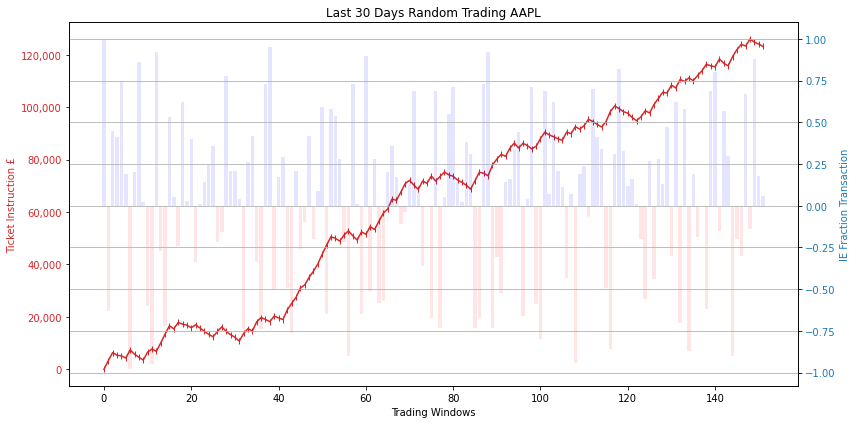

In [23]:
construct_results_viz(test_results)

In [24]:
test_results

,Total Investment Instructions,Trading Window Instruction,Trading Window Share Price,Total Window Unit Order,IE Registry Fractionals,IE Total Registry
Trading Window,,,,,,
0,0.00,0.00,0.00,1.00,1.00,1.00
1,3309.58,3309.58,124.28,26.63,-0.63,0.37
2,6379.80,3070.22,125.06,24.55,0.45,0.82
3,5340.83,-1038.97,123.54,-8.41,0.41,1.23
4,5120.52,-220.31,125.89,-1.75,0.75,1.98
...,...,...,...,...,...,...
147,123311.14,-657.99,179.29,-3.67,0.67,0.97
148,126026.95,2715.81,179.38,15.14,-0.14,0.83
149,124800.93,-1226.02,178.20,-6.88,0.88,1.71
